**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

**Connecting to TPU**

In [3]:
print(tf.__version__)

2.13.0


In [4]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE

**Loading the Dataset**

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [6]:
#monet_files= tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
#photo_files= tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
monet_files= tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_files= tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [7]:
print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [8]:
IMAGE_SIZE= [256,256]                                            # desired/required size of image

def decode_img(image):                                           # function for decoding the image present in jpeg format
    image= tf.image.decode_jpeg(image,channels= 3)               # 3 channels because of RGB
    image= (tf.cast(image, tf.float32)/255)*2 -1                 # converting the pixel values in range [-1,1]
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])             # reshaping the image to proper size
    return image

def read_tfrec(example):                                         # function for extracting image from TFRecord format
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),      # [] denotes fixed length feature where length= 1
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

In [9]:
def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrec)                                   # (num_parallel_calls= AUTOTUNE) in  case of TPU
    return data

In [10]:
monet_data= load_data(monet_files).batch(1)                      # forming batches of size=1 (i.e. 1 image processed at a time)
photo_data= load_data(photo_files).batch(1)

In [11]:
monet_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [12]:
ex_monet= next(iter(monet_data))
ex_photo= next(iter(photo_data))

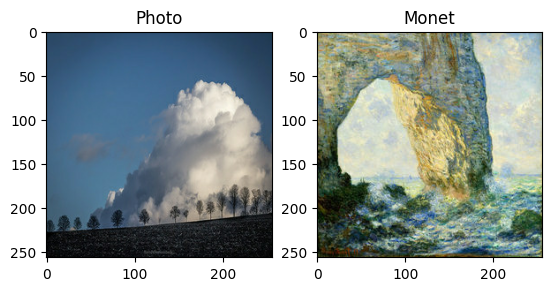

In [13]:
plt.subplot(1,2,1)                                       # creating a subplot with 1 row and 2 columns
plt.title('Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(ex_monet[0]*0.5 +0.5)                   

**Building the Generator (UNET Architecture)**

In [14]:
def downsample(filters, size, instance_norm= True):                                   # for extracting important features (size is reduced)
    initializer= tf.random_normal_initializer(0,0.02)                                 # mean=0 and standard deviation=0.02 for initializing kernel weights
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     # groups= -1 to make it work like Instance Normalization
   
    model.add(LeakyReLU())
    
    return model

In [15]:
# def downsample(filters, size, instance_norm= True):                                   # for extracting important features (size is reduced)
#     initializer= tf.random_normal_initializer(0,0.02)                                 # mean=0 and standard deviation=0.02 for initializing kernel weights
#     gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
#     i= Input(shape= (None,None,filters))                                    
#     x= Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False) (i)
    
#     if instance_norm:
#          x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)        # groups= -1 to make it work like Instance Normalization
   
#     x= LeakyReLU() (x)
    
#     model= Model(i,x)
    
#     return model

In [16]:
def upsample(filters, size, dropout= False):                                         # for locating features accurately using skip connections 
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

In [17]:
# def upsample(filters, size, dropout= False):                                         # for locating features accurately using skip connections 
#     initializer= tf.random_normal_initializer(0,0.02)
#     gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
#     i= Input(shape= (None,None,filters))
#     x= Conv2DTranspose(filters, size, strides= 2, padding='same', kernel_initializer= initializer, use_bias= False) (i)
#     x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    
#     if dropout:
#         x= Dropout(0.5) (x)
        
#     model= Model(i,x)
    
#     return model

In [18]:
def generator():
    down_stack= [
        downsample(64,4,False),                 # size= (128,128,64)  (size denotes the dimensions of image after the corresponding layer/operation)
        downsample(128,4),                      # size= (64,64,128)
        downsample(256,4),                      # size= (32,32,256)
        downsample(512,4),                      # size= (16,16,512)
        downsample(512,4),                      # size= (8,8,512)
        downsample(512,4),                      # size= (4,4,512)
        downsample(512,4),                      # size= (2,2,512)
        downsample(512,4),                      # size= (1,1,512)
    ]
    
    up_stack= [
        upsample(512,4,True),                   # size= (2,2,1024)  (no. of channels doubled because upsample block concats output of last downsample block)    
        upsample(512,4,True),                   # size= (4,4,1024)
        upsample(512,4,True),                   # size= (8,8,1024)
        upsample(512,4),                        # size= (16,16,1024)  (dropout= false so that information is maintained for generating detailed outputs)
        upsample(256,4),                        # size= (32,32,512)
        upsample(128,4),                        # size= (64,64,256)
        upsample(64,4)                          # size= (128,128,128)
    ]
    
    initializer= tf.random_normal_initializer(0,0.02)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     # 3 output channels required
    
    i= Input(shape= [256,256,3])                # input layer
    x= i
    skips= []
    for down in down_stack:                     # downsampling
        x= down (x) 
        skips.append(x)                         # appending skip connections to the 'skips' list
        
    skips= reversed(skips[:-1])                 # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack,skips):        # upsampling and concatenating output with skip connection
        x= up (x)
        x= Concatenate() ([x,skip])
        
    x= last_layer(x)                            # last layer (Conv2DTranspose) for generating the final output 
    
    model= Model(i,x)
    
    return model

**Building the Discriminator**

In [19]:
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                 # size= (128,128,64) 
    x= downsample(128,4) (x)                                # size= (64,64,128) 
    x= downsample(256,4) (x)                                # size= (32,32,256)
    
    x= ZeroPadding2D() (x)                                  # size= (34,34,256)    (1 pixel padding is added at top,bottom,left,right) 
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 1, padding= 'same', kernel_initializer= initializer, use_bias= False) (x)      # size= (31,31,512) (size= orig - kernel + 1)
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                  # size= (33,33,512)    (zero padding applied to maintain spatial information)
    
    x= Conv2D(1, 4, strides= 1, padding= 'same', kernel_initializer= initializer) (x)       # size= (30,30,1) 
                                                                                            # sigmoid not used to output unbounded logits
    model= Model(i,x)                                                                       # (more numerically stable during training)
    
    return model

**Initializing the generator & discriminator objects**

In [20]:
# with strategy.scope():
monet_generator= generator()                     # photo to monet-esque
monet_discriminator= discriminator()             # to differentiate between generated monet-esque images and real monet-esque images
photo_generator= generator()                     # monet-esque to photo
photo_discriminator= discriminator()             # to differentiate between generated 'normal' images and real 'normal' images

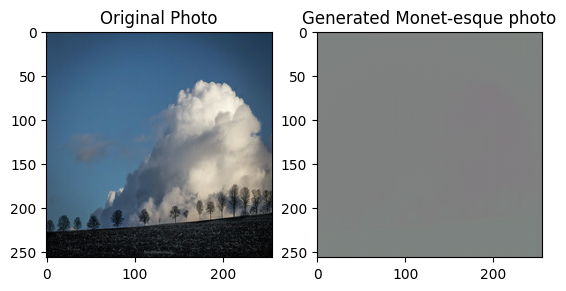

In [21]:
photo_to_monet= monet_generator(ex_photo)                # won't generate monet-esque photos as we have not fit the data into generator yet

plt.subplot(1,2,1)                                       # creating a subplot with 1 row and 2 columns
plt.title('Original Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)                   

**Building the CycleGAN**

In [22]:
class CycleGAN(keras.Model):                       # CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.
    def __init__(                                  # arguments to be passed in a CycleGAN class object   
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        lambda_cycle= 10                           # 'lambda_cycle' controls the importance of cycle consistency loss
    ):
        super(CycleGAN,self).__init__()            # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen= monet_gen                      # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_disc= monet_disc
        self.p_gen= photo_gen
        self.p_disc= photo_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()             # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                # automatically invoked when fit() method is called 
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             # to keep a track of operations (persistent= True bcz of multiple calls to Gradient())
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and then cycled back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and then cycled back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check by inputing real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check by inputing fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

**Loss Functions**

In [23]:
# with strategy.scope():
def gen_loss_fn(generated):            # from_logits=True used bcz disc return unbounded values & NONE redn used to return tensor of indiv losses bcz those values are returned at each epoch
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [24]:
# with strategy.scope():
def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss= (loss_real + loss_fake)/2
        
    return total_loss

In [25]:
# with strategy.scope():
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
        
    return lambda_cycle*loss                        # lambda controls the weight of cycle consistency loss in overall loss 

In [26]:
# with strategy.scope():
def identity_loss_fn(real, same, Lambda):           # LAMBDA has same use as in case of cycle consistency loss
    loss= tf.reduce_mean(tf.abs(real - same))
        
    return Lambda*loss*0.5                          # factor of '0.5' used for normalization purposes

**Optimizers**

In [27]:
# with strategy.scope():
m_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

**Compiling and Training/Fitting**

In [28]:
# with strategy.scope():
cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [29]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 50)

Epoch 1/50


2024-01-25 11:03:03.359923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_10/dropout_2/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 208s 469ms/step - gen_monet_loss: 5.0982 - gen_photo_loss: 5.2887 - disc_monet_loss: 0.6674 - disc_photo_loss: 0.6479
Epoch 2/50
300/300 [==============================] - 143s 473ms/step - gen_monet_loss: 3.5525 - gen_photo_loss: 3.6420 - disc_monet_loss: 0.6822 - disc_photo_loss: 0.6683
Epoch 3/50
300/300 [==============================] - 143s 472ms/step - gen_monet_loss: 3.4484 - gen_photo_loss: 3.5177 - disc_monet_loss: 0.6776 - disc_photo_loss: 0.6696
Epoch 4/50
300/300 [==============================] - 143s 472ms/step - gen_monet_loss: 3.3661 - gen_photo_loss: 3.4566 - disc_monet_loss: 0.6661 - disc_photo_loss: 0.6517
Epoch 5/50
300/300 [==============================] - 143s 472ms/step - gen_monet_loss: 3.2421 - gen_photo_loss: 3.4076 - disc_monet_loss: 0.6674 - disc_photo_loss: 0.6243
Epoch 6/50
300/300 [==============================] - 143s 473ms/step - gen_monet_loss: 3.1057 - gen_photo_loss: 3.2580 - disc_monet_loss: 0.6601 - dis

**Observing the Monet-esque Photos**

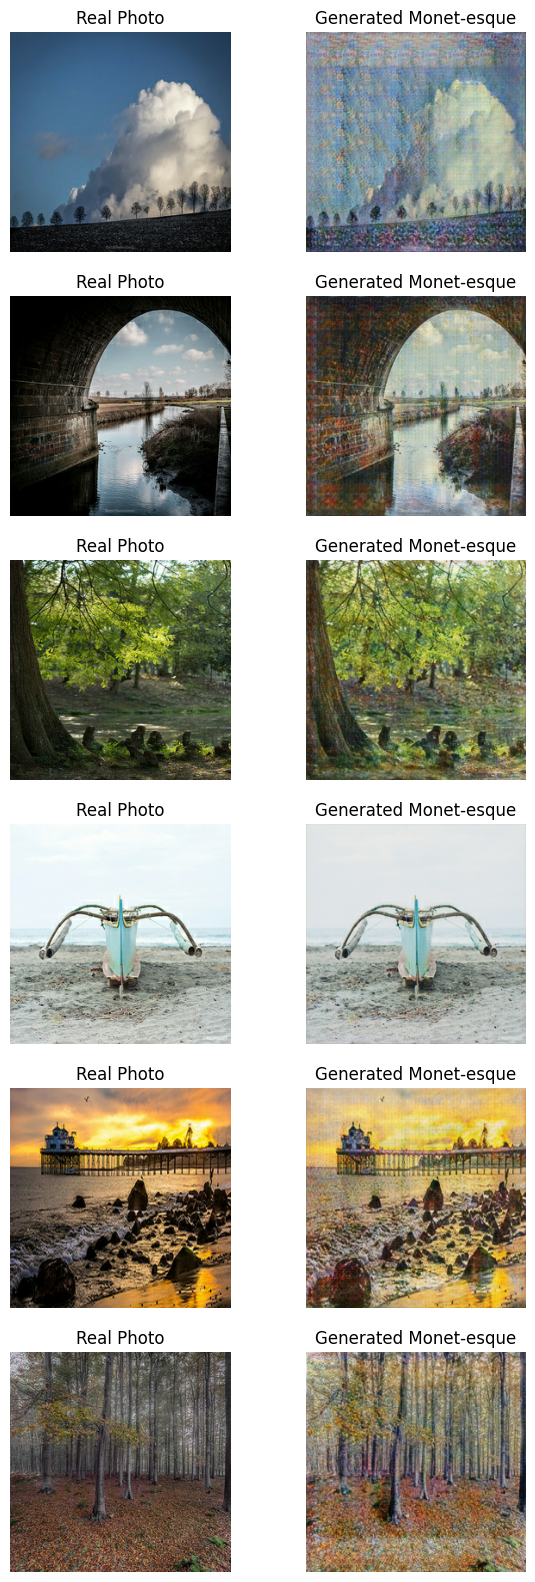

In [30]:
fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

**Submission File Creation**

In [31]:
import PIL
!mkdir ../images

In [32]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [33]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

**This was my first time working on CycleGAN along with other topics such as UNET Architecture...so I followed AMY JANG's notebook for reference. I REALLY loved her work!! I spent a lot of time understanding the concepts she used and apply those concepts on my own along with adding comments to help people understand important steps better... I will provide the link to her notebook here...so please do check it out!! And...Thank You for checking my notebook out!! :)
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook**